# Implementation of Naive Bayes Classifier 

In [ ]:
# !pip install -U statsmodels

In [1]:
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# we dont need this anymore as I have modified the file which also gives us processed data for test set
# module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
# module_name = module_url.split('/')[-1]
# print(f'Fetching {module_url}')
# #with open("file_1.txt") as f1, open("file_2.txt") as f2
# with request.urlopen(module_url) as f, open(module_name,'w') as outf:
#   a = f.read()
#   outf.write(a.decode('utf-8'))
import os
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer

class DontPatronizeMe:

	def __init__(self, train_path, test_path):

		self.train_path = train_path
		self.test_path = test_path
		self.train_task1_df = None
		self.train_task2_df = None
		self.test_set_df = None

	def load_task1(self):
		"""
		Load task 1 training set and convert the tags into binary labels. 
		Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
		Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.
		It returns a pandas dataframe with paragraphs and labels.
		"""
		rows=[]
		with open(os.path.join(self.train_path, 'dontpatronizeme_pcl.tsv')) as f:
			for line in f.readlines()[4:]:
				par_id=line.strip().split('\t')[0]
				art_id = line.strip().split('\t')[1]
				keyword=line.strip().split('\t')[2]
				country=line.strip().split('\t')[3]
				t=line.strip().split('\t')[4]#.lower()
				l=line.strip().split('\t')[-1]
				if l=='0' or l=='1':
					lbin=0
				else:
					lbin=1
				rows.append(
					{'par_id':par_id,
					'art_id':art_id,
					'keyword':keyword,
					'country':country,
					'text':t, 
					'label':lbin, 
					'orig_label':l
					}
					)
		df=pd.DataFrame(rows, columns=['par_id', 'art_id', 'keyword', 'country', 'text', 'label', 'orig_label']) 
		self.train_task1_df = df

	def load_task2(self, return_one_hot=True):
		# Reads the data for task 2 and present it as paragraphs with binarized labels (a list with seven positions, "activated or not (1 or 0)",
		# depending on wether the category is present in the paragraph).
		# It returns a pandas dataframe with paragraphs and list of binarized labels.
		tag2id = {
				'Unbalanced_power_relations':0,
				'Shallow_solution':1,
				'Presupposition':2,
				'Authority_voice':3,
				'Metaphors':4,
				'Compassion':5,
				'The_poorer_the_merrier':6
				}
		print('Map of label to numerical label:')
		print(tag2id)
		data = defaultdict(list)
		with open (os.path.join(self.train_path, 'dontpatronizeme_categories.tsv')) as f:
			for line in f.readlines()[4:]:
				par_id=line.strip().split('\t')[0]
				art_id = line.strip().split('\t')[1]
				text=line.split('\t')[2]#.lower()
				keyword=line.split('\t')[3]
				country=line.split('\t')[4]
				start=line.split('\t')[5]
				finish=line.split('\t')[6]
				text_span=line.split('\t')[7]
				label=line.strip().split('\t')[-2]
				num_annotators=line.strip().split('\t')[-1]
				labelid = tag2id[label]
				if not labelid in data[(par_id, art_id, text, keyword, country)]:
					data[(par_id,art_id, text, keyword, country)].append(labelid)

		par_ids=[]
		art_ids=[]
		pars=[]
		keywords=[]
		countries=[]
		labels=[]

		for par_id, art_id, par, kw, co in data.keys():
			par_ids.append(par_id)
			art_ids.append(art_id)
			pars.append(par)
			keywords.append(kw)
			countries.append(co)

		for label in data.values():
			labels.append(label)

		if return_one_hot:
			labels = MultiLabelBinarizer().fit_transform(labels)
		df = pd.DataFrame(list(zip(par_ids, 
									art_ids, 
									pars, 
									keywords,
									countries, 
									labels)), columns=['par_id',
														'art_id', 
														'text', 
														'keyword',
														'country', 
														'label',
														])
		self.train_task2_df = df


	def load_test(self):
		#self.test_df = [line.strip() for line in open(self.test_path)]
		rows=[]
		with open(self.test_path) as f:
			for line in f:
				t=line.strip().split('\t')
				rows.append(t)
		self.test_set_df = pd.DataFrame(rows, columns="par_id art_id keyword country text".split())
		#drop the art_id,country columns
		self.test_set_df = self.test_set_df.drop(['art_id','country'], axis=1)
		#rename keyword to community
		self.test_set_df = self.test_set_df.rename(columns={'keyword':'community'})

In [3]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [4]:
dpm = DontPatronizeMe(r'/kaggle/input/nlp-cw/', r'/kaggle/input/nlp-cw/task4_test.tsv') # train and test paths
dpm.load_task1() # load task 1 training set
dpm.load_test() # load test set

In [5]:
print(dpm.train_task1_df.shape) #train and dev set, train needs to be split into train and dev(for internal evaluation)
print(dpm.test_set_df.shape) #official test set

(10469, 7)
(3832, 3)


In [6]:
allData = dpm.train_task1_df # load training data
allData.head()

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0


In [7]:
trainIDs = pd.read_csv(r'/kaggle/input/nlp-cw/train_semeval_parids-labels.csv')
devIDS = pd.read_csv(r'/kaggle/input/nlp-cw/dev_semeval_parids-labels.csv')
trainIDs.par_id = trainIDs.par_id.astype(str)
devIDS.par_id = devIDS.par_id.astype(str)

In [8]:
# building the trainSet
rows = [] # will contain par_id, label and text
for idx in range(len(trainIDs)):  
  parid = trainIDs.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  keyword = allData.loc[allData.par_id == parid].keyword.values[0]
  text = allData.loc[allData.par_id == parid].text.values[0]
  label = allData.loc[allData.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })

In [9]:
trainData = pd.DataFrame(rows)
trainData.head()

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1


In [10]:
rows = [] # will contain par_id, label and text
for idx in range(len(devIDS)):  
  parid = devIDS.par_id[idx]
  #print(parid)
  # select row from original dataset
  keyword = allData.loc[allData.par_id == parid].keyword.values[0]
  text = allData.loc[allData.par_id == parid].text.values[0]
  label = allData.loc[allData.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })

In [11]:
devData = pd.DataFrame(rows)
devData.head()

,par_id,community,text,label
0,4046,hopeless,We also know that they can benefit by receivin...,1
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1


In [12]:
testData = dpm.test_set_df
testData.head()

,par_id,community,text
0,t_0,vulnerable,"In the meantime , conservatives are working to..."
1,t_1,women,In most poor households with no education chil...
2,t_2,migrant,The real question is not whether immigration i...
3,t_3,migrant,"In total , the country 's immigrant population..."
4,t_4,vulnerable,"Members of the church , which is part of Ken C..."


In [23]:
trainingDataPrime =trainData

In [24]:
trainingDataPrime.shape

(8375, 4)

In [33]:
# downsample negative instances
dataPos = trainData[trainData.label==1]
numberOfPos = len(dataPos)
trainingDataPrime = pd.concat([dataPos,trainData[trainData.label==0][:numberOfPos*2]])
print(trainingDataPrime.shape)

(2382, 4)


In [14]:
#splitting the train data into train and validation set

# trainingData, validationData = train_test_split(trainingDataPrime, test_size=0.1, random_state=42)
# print(trainingData.shape,validationData.shape)

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,f1_score

In [35]:
# Data Preprocessing
vectorizer = TfidfVectorizer(stop_words='english',use_idf=True, max_df=0.7)
X_train = vectorizer.fit_transform(trainingDataPrime['text'])
X_dev = vectorizer.transform(devData['text'])

In [36]:
Y_train = trainingDataPrime['label']
Y_dev = devData['label']

In [37]:
print(X_train.shape)
print()
print(X_dev.shape)

(2382, 13256)

(2094, 13256)


In [38]:
# Compute Class Priors
nb = MultinomialNB()
nb.fit(X_train, Y_train)

MultinomialNB()

In [39]:
# Getting predictions for Dev data
Y_dev_pred = nb.predict(X_dev)

### Evaluation

In [40]:
# Evaluate the Model
accuracy_nb = accuracy_score(Y_dev, Y_dev_pred)
f1_score_nb = f1_score(Y_dev, Y_dev_pred, average='binary',pos_label=1)
precision_nb, recall_nb, f1_beta_nb, support_nb = precision_recall_fscore_support(Y_dev, Y_dev_pred)

In [41]:
print("Accuracy:", accuracy_nb)
print("F1 score:",f1_score_nb)
print("Precision:", precision_nb[1])
print("Recall:", recall_nb[1])
print("Occurances of datapoints:",support_nb)

Accuracy: 0.9059216809933143
F1 score: 0.08372093023255814
Precision: 0.5625
Recall: 0.04522613065326633
Occurances of datapoints: [1895  199]


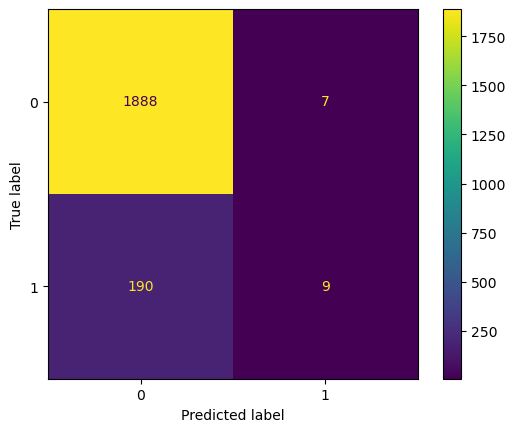

In [43]:
cm = confusion_matrix(Y_dev, Y_dev_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

## Misclassified example

In [44]:
indices = np.where((Y_dev ==1) & (Y_dev_pred ==0))[0]
corr_indices = np.where((Y_dev ==1) & (Y_dev_pred ==1))[0]
print(indices)
print("\n Correctly prdeicted indices")
print(corr_indices)
wrong_preds = devData.iloc[indices]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  64  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  92  93
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 135 136 137 138 139 140 141 142 143 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 183 184 185 186 188
 189 190 191 192 193 194 195 196 197 198]

 Correctly prdeicted indices
[ 36  63  65  91  94 134 144 182 187]


### Features Importance

In [ ]:
# Get the vocabulary (i.e., the mapping between feature indices and feature names)
vocabulary = vectorizer.vocabulary_
# Get the feature probabilities
feature_probs = np.exp(nb.feature_log_prob_)
# Extract Features
feature_names = vectorizer.get_feature_names_out()

In [ ]:
# Analysing for class 0
sorted_features = sorted(zip(feature_names, (feature_probs[0])), key=lambda x: x[1], reverse=True)
for i in range(10):
    print(sorted_features[i])

In [ ]:
# Analysing for class 1
sorted_features = sorted(zip(feature_names, (feature_probs[1])), key=lambda x: x[1], reverse=True)
for i in range(10):
    print(sorted_features[i])

In [ ]:
# Compute the feature importance for each class label
class_importance = []
for i, class_name in enumerate(set(devData['label'])):
#     print("Class", i)
    class_probs = feature_probs[i]
    sorted_probs = sorted(class_probs, reverse=True)
    top_features = [list(vocabulary.keys())[list(vocabulary.values()).index(j)] for j in [list(class_probs).index(k) for k in sorted_probs][:10]]
    class_importance.append((class_name, top_features))

In [ ]:
top_features = []
# Print the feature importance for each class label
for class_name, top_features in class_importance:
#     top_features.append()
    print(f"Top features for {class_name}: {', '.join(top_features)}")

### Features Probability

In [ ]:
# Feature importances
# feature_importances = model.coef_[0]

# Feature probabilities
feature_probabilities_1 = np.exp(model.feature_log_prob_[1])
df = pd.DataFrame({'feature': vectorizer.get_feature_names_out(), 'probability': feature_probabilities_1})
df = df.sort_values('probability', ascending=False)

In [ ]:
sns.reset_orig()

In [ ]:
top_k = 10
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot( df['feature'][:top_k],df['probability'][:top_k]*100, color='r', marker='o')
ax.set_ylabel('Feature log Probability(10^-3)', fontweight='bold')
# plt.yscale('log')
ax.set_xlabel('Feature', fontweight='bold')
plt.grid()
plt.title("Top 10 feature probability of class label 1(PCL)", fontweight='bold')
plt.savefig("nb_features_1.pdf")
plt.show()

In [ ]:
# Feature importances
# feature_importances = model.coef_[0]

# Feature probabilities
feature_probabilities_0 = np.exp(model.feature_log_prob_[0])
df = pd.DataFrame({'feature': vectorizer.get_feature_names_out(), 'probability': feature_probabilities_0})
df = df.sort_values('probability', ascending=False)

In [ ]:
top_k = 10
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot( df['feature'][:top_k],df['probability'][:top_k]*100, color='r', marker='o')
ax.set_ylabel('Feature log Probability(10^-3)', fontweight='bold')
# plt.yscale('log')
ax.set_xlabel('Feature', fontweight='bold')
plt.grid()
plt.title("Top 10 feature probability of class label 0(Non PCL)", fontweight='bold')
plt.savefig("nb_features_0.pdf")
plt.show()

In [ ]:
ana_df = df.iloc[:10]

In [ ]:
# Calculate correlation matrix
corr_matrix = ana_df.corr()

# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [ ]:
model = nb

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_theme()

In [ ]:
top_k_features = 20
# Compute the feature probabilities
probs = nb.feature_log_prob_[:,:50]

# Compute the correlation matrix between features
corr_matrix = np.corrcoef(probs)

print(probs.shape)
# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

In [ ]:
# Get the feature probabilities for the positive class
pos_probs = nb.feature_log_prob_[0]

# Convert from log-probabilities to probabilities
pos_probs = np.exp(pos_probs)

# Plot a histogram of the feature probabilities
plt.hist(pos_probs, bins=5)
plt.xlabel('Feature Probability')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Sensitivity analysis: TODO

In [ ]:
pos_probs = nb.feature_log_prob_[1]
pos_probs = np.exp(pos_probs)

print('Minimum feature probability:', np.min(pos_probs))
print('Maximum feature probability:', np.max(pos_probs))
print('Standard deviation of feature probabilities:', np.std(pos_probs))

****